데이터 변환 과정과 머신러닝 모델을 쉽게 연결해주는 Pipeline 파이썬 클래스  
(Pipeline과 GridSearchCV를 함께 사용하여 각 처리 단계에서 필요한 매개변수 탐색을 동시에 수행)

In [1]:
# %load basic
from IPython.display import set_matplotlib_formats, display
import numpy as np
import pandas as pd
import graphviz
import os
import mglearn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
from cycler import cycler
%matplotlib inline

font_name = font_manager.FontProperties(fname = "C:/Windows/Fonts/H2GTRM.TTF").get_name()
rc('font', family = font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# 데이터를 분할하고 최솟값, 최댓값을 찾아 데이터의 스케일을 바꾸고 SVM을 훈련시키는 코드
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다.
scaler = MinMaxScaler().fit(X_train)

In [3]:
# 훈련 데이터의 스케일을 조정합니다.
X_train_scaled = scaler.transform(X_train)
svm = SVC()

# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다.
svm.fit(X_train_scaled, y_train)

# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다.
X_test_scaled = scaler.transform(X_test)
print("테스트 점수 : {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수 : 0.95


C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# 6.1 데이터 전처리와 매개변수 선택

In [4]:
from sklearn.model_selection import GridSearchCV

# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
paramg = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid = paramg, cv = 5)
grid.fit(X_train_scaled, y_train)

print("최상의 교차 검증 정확도 : {:.2f}".format(grid.best_score_))
print("테스트 점수 : {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수 : ", grid.best_params_)

최상의 교차 검증 정확도 : 0.98
테스트 점수 : 0.97
최적의 매개변수 :  {'C': 1, 'gamma': 1}


1. 데이터의 최솟값과 최댓값을 계산할 때 학습을 위해 훈련 세트에 있는 모든 데이터를 사용  
2. 스케일이 조정된 훈련 데이터에서 교차 검증을 사용해 그리드 서치 수행  
-> 데이터 스케일을 조정할 때 검증 폴드에 들어있는 정보까지 이미 사용  
-> 새로운 데이터가 관측되면 이 데이터는 훈련 데이터의 스케일 조정에 사용되지 않은 것이라 최솟값과 최댓값이 훈련 데이터와 다를 수 있음

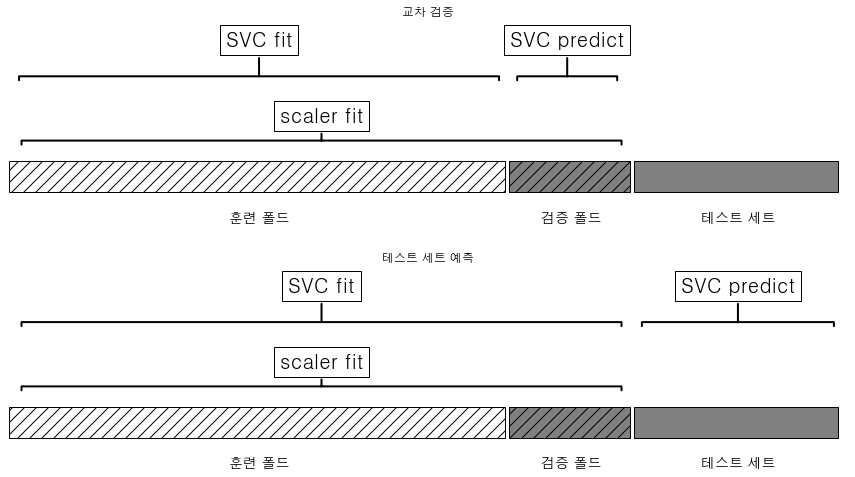

In [5]:
mglearn.plots.plot_improper_processing()

교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때 올바로 분류하지 못함  
-> 이 문제를 해결하기 위해서는 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄줘야 함  
    (데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 훈련 부분에만 적용되어야 하므로 교차 검증 반복 안에 있어야 함)

# 6.2 파이프라인 구축하기